# Equations of motion

Derives the full Hamiltonian and EOM for a general triaxial body, expanding on the work done in rigidbody.pdf

In [1]:
import numpy as np
import sympy as sp
from IPython.display import display
from sympy.vector import CoordSys3D
# https://docs.sympy.org/latest/modules/simplify/fu.html#
# TRpower does power reduction, TR8 does product-to-sum, TR11 is double angle
from sympy.simplify.fu import TRpower, TR8, TR11
sp.init_printing(use_latex=True)
N = CoordSys3D('N')

In [2]:
l, g, h, L, S, Sp, Sz, Szp = sp.symbols(r'l g h \Lambda S S^{\prime} S_z S_z^{\prime}', real=True, positive=True)
A, B, C = sp.symbols('A B C', real=True, positive=True)
phi, q, y, i, J, M = sp.symbols('\phi \theta \psi i J M', real=True)
G, m, a, n = sp.symbols('G m a n', real=True, positive=True)
e0 = n**2 # G * m / a**3

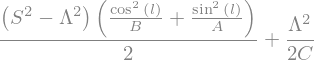

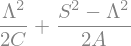

In [3]:
T = (
    (sp.sin(l)**2/A + sp.cos(l)**2/B) * (S**2 - L**2)
    + L**2 / C
) / 2
T_obl = sp.trigsimp(T.subs({B:A}))
display(T)
display(T_obl)

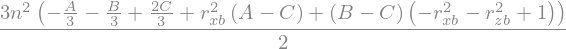

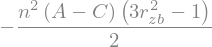

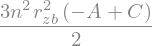

In [4]:
# drop constant term
rx_b, rz_b = sp.symbols('r_{xb} r_{zb}')
V = 3 * e0 / 2 * ((A - C) * rx_b**2 + (B - C) * (1 - rx_b**2 - rz_b**2) + (2 * C - (A + B)) / 3)
V_obl_classic = sp.factor(sp.simplify(V.subs({B:A})))
V_obl_fact = 3 * e0 * (C - A) / 2
V_obl_basic = sp.simplify(V_obl_classic + V_obl_fact / 3)
display(V)
display(V_obl_classic)
display(V_obl_basic)

In [5]:
rhat_s = np.array([sp.cos(M), sp.sin(M), 0])

### Helper Functions

In [6]:
def hamilton_EOM(H):
    return (
        sp.simplify(sp.diff(H, L)), # dldt
        sp.simplify(sp.diff(H, S)), # dgdt
        sp.simplify(sp.diff(H, Sz)), # dhdt
        sp.simplify(sp.diff(H, l)), # dLdt
        sp.simplify(sp.diff(H, g)), # dSdt
        sp.simplify(sp.diff(H, h)), # dSzdt
    )
def get_euler(q1, q2, q3):
    c1 = sp.cos(q1)
    c2 = sp.cos(q2)
    c3 = sp.cos(q3)
    s1 = sp.sin(q1)
    s2 = sp.sin(q2)
    s3 = sp.sin(q3)
    return np.array([
        [c1 * c3 - c2 * s1 * s3, -c1 * s3 - c2 * c3 * s1, s1 * s2],
        [c3 * s1 + c1 * c2 * s3, c1 * c2 * c3 - s1 * s3, -c1 * s2],
        [s2 * s3, c3 * s2, c2]
    ])
def body_to_space(v_b):
    v_A = np.matmul(get_euler(g, J, l), v_b)
    v_s = np.matmul(get_euler(h, i, 0), v_A)
    return v_s

In [7]:
khat_b = np.array([0, 0, 1])
khat_s = body_to_space(khat_b)
display(khat_s[0])
display(khat_s[1])
display(khat_s[2])

In [8]:
ihat_b = np.array([1, 0, 0])
ihat_s = body_to_space(ihat_b)

## B=A Limit

### Free rotation

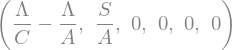

In [9]:
# get the right EOM for free rotation
eoms = hamilton_EOM(T_obl)
display(eoms)

### With Grav Potential: handling rdotk

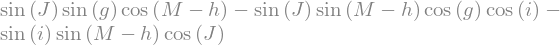

In [10]:
rdotk = sp.simplify(np.dot(rhat_s, khat_s))
display(rdotk)

Now we assume $h = 0$ for simplicity, and mask out the $J$ and $i$ trig functions to avoid getting them expanded

In [11]:
sJ, cJ, si, ci = sp.symbols('sJ cJ si ci', real=True)
mask_Ji = {
    sp.sin(J): sJ,
    sp.cos(J): cJ,
    sp.sin(i): si,
    sp.cos(i): ci,
}
mask_Ji_revert = {v: k for k, v in mask_Ji.items()}
rdotk_masked = rdotk.subs({h:0}).subs(mask_Ji)
# TRpower does power-reduction, TR8 does product-to-sum
rdotksq_sumandangle_t8 = sp.expand(TR8(sp.expand(TRpower(sp.expand(rdotk_masked**2)))) * 8)
# display(TR8(sp.expand(TRpower(sp.expand(rdotk_masked**2)))))

Finally, we have the terms of $(r \cdot k)^2$. Let's collect them as functions of their argument and print them out.

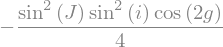

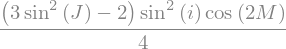

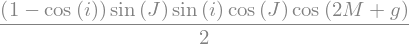

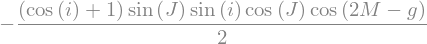

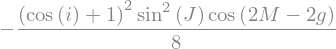

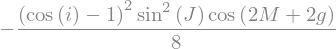


And the remaining terms:


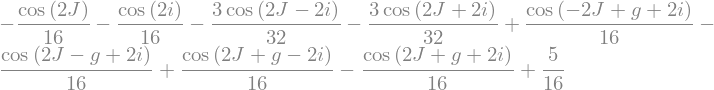

In [12]:
# collect terms for easier printing
terms = (sp.cos(2*g), sp.cos(2*M), sp.cos(2*M + g), sp.cos(2*M - g), sp.cos(2*M - 2*g), sp.cos(2*M + 2*g))
rdotksq_sumandangle = sp.collect(
    rdotksq_sumandangle_t8,
    terms,
).subs(mask_Ji_revert) / 8
remainder = rdotksq_sumandangle
for t in terms:
    display(sp.simplify(rdotksq_sumandangle.coeff(t)) * t)
    remainder -= rdotksq_sumandangle.coeff(t) * t
print('\nAnd the remaining terms:')
display(sp.simplify(remainder))

## Hamiltonians

### 2:1

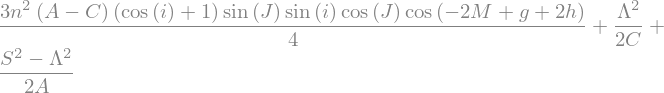

In [13]:
rdotksq_21 = sp.simplify(rdotksq_sumandangle.coeff(sp.cos(2 * M - g))) * sp.cos(2 * M - 2 * h - g)
V_obl_withdot21 = sp.simplify(V_obl_basic.subs({rz_b**2: rdotksq_21}))
# not yet canonical
H_obl_nc21 = T_obl + V_obl_withdot21
display(H_obl_nc21)

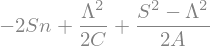

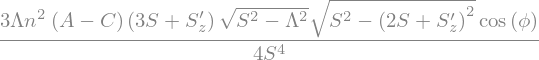

In [14]:
# change to canonical variables
def mysub(e):
    return e.subs({
        2 * M - 2 * h - g: phi,
        sp.cos(i): Sz / S,
        sp.sin(i): sp.sqrt(1 - (Sz / S)**2),
        sp.cos(J): L / S,
        sp.sin(J): sp.sqrt(1 - (L / S)**2)
    }).subs({Sz: 2 * S + Szp})
V_obl_withdot21_2 = sp.simplify(mysub(V_obl_withdot21))
T_obl21_2 = T_obl - 2 * n * S
H_obl21 = mysub(T_obl21_2) + V_obl_withdot21_2
display(mysub(T_obl21_2))
display(V_obl_withdot21_2)

Get equations of motion...

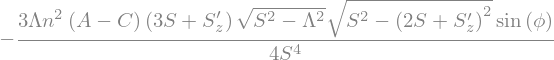

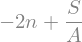

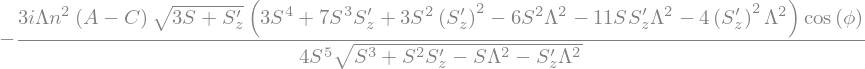

In [15]:
dphidt21 = sp.diff(H_obl21, S)
dSdt21 = sp.diff(H_obl21, phi)
display(dSdt21)
dphidt21_terms = dphidt21.as_independent(sp.cos(phi))
display(dphidt21_terms[0])
display(sp.simplify(sp.factor(dphidt21_terms[1])))

## 1:1 Resonance

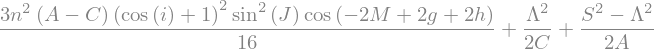

In [16]:
rdotksq_11 = sp.simplify(rdotksq_sumandangle.coeff(sp.cos(2 * M - 2 * g))) * sp.cos(2 * M - 2 * h - 2 * g)
V_obl_withdot11 = sp.simplify(V_obl_basic.subs({rz_b**2: rdotksq_11}))
# not yet canonical
H_obl_nc11 = T_obl + V_obl_withdot11
display(H_obl_nc11)

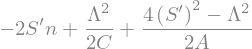

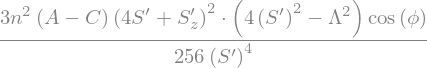

In [17]:
# change to canonical variables
def mysub(e):
    return e.subs({
        2 * M - 2 * h - 2 * g: phi,
        sp.cos(i): Sz / S,
        sp.sin(i): sp.sqrt(1 - (Sz / S)**2),
        sp.cos(J): L / S,
        sp.sin(J): sp.sqrt(1 - (L / S)**2)
    }).subs({
        Sz: 2 * Sp + Szp,
        S: 2 * Sp,
    })
V_obl_withdot11_2 = sp.simplify(mysub(V_obl_withdot11))
T_obl11_2 = T_obl - 2 * n * Sp
H_obl11 = mysub(T_obl11_2) + V_obl_withdot11_2
display(mysub(T_obl11_2))
display(V_obl_withdot11_2)

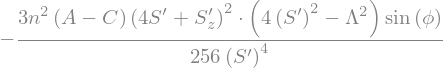

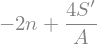

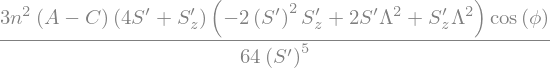

In [18]:
dphidt11 = sp.diff(H_obl11, Sp)
dSpdt11 = sp.diff(H_obl11, phi)
display(dSpdt11)
dphidt11_terms = dphidt11.as_independent(sp.cos(phi))
display(dphidt11_terms[0])
display(sp.simplify(sp.factor(dphidt11_terms[1])))

# Triaxial

Note that the triaxial dynamics are pretty ugly, but the changes to the Hamiltonian at the level of the $2M - 2h - \{1,2\}g$ resonances are minimal. We show this below.

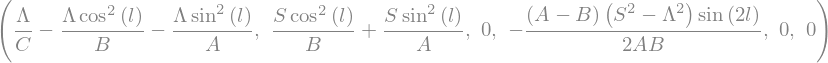

In [19]:
# get the right EOM for free rotation
eoms = hamilton_EOM(T)
display(eoms)

Now, try to get the full potential

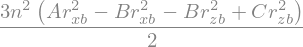

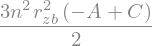

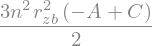

In [20]:
V_tri = V - n**2 * (2*B - C - A) / 2
display(sp.simplify(sp.expand(V_tri)))
# verify still correct potential
display(V_obl_basic)
display(sp.simplify(V_tri.subs({B:A})))

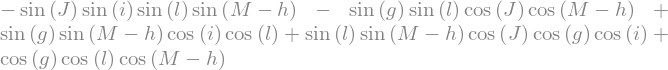

In [21]:
rdoti = sp.simplify(np.dot(rhat_s, ihat_s))
display(rdoti)

In [22]:
sJ, cJ, si, ci = sp.symbols('sJ cJ si ci', real=True)
mask_Ji = {
    sp.sin(J): sJ,
    sp.cos(J): cJ,
    sp.sin(i): si,
    sp.cos(i): ci,
}
mask_Ji_revert = {v: k for k, v in mask_Ji.items()}
rdoti_masked = rdoti.subs({h:0}).subs(mask_Ji)
# TRpower does power-reduction, TR8 does product-to-sum
rdotisq_sumandangle_t8 = sp.expand(TR8(sp.expand(TRpower(sp.expand(rdoti_masked**2)))) * 8)
# display(rdotisq_sumandangle_t8)

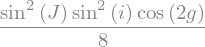

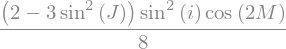

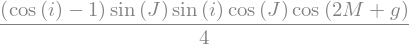

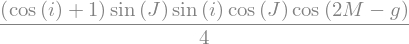

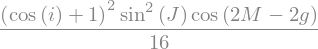

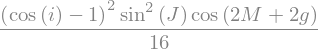

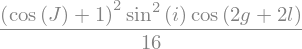

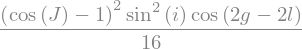

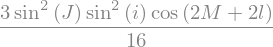

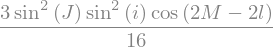

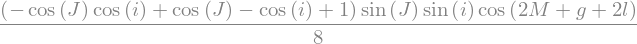

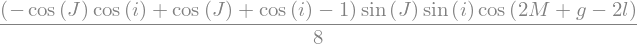

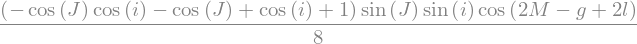

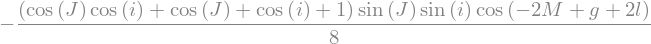

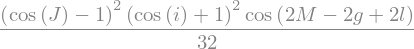

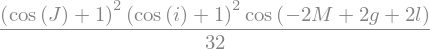

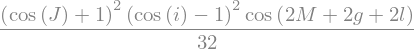

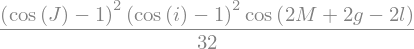


And remainder:


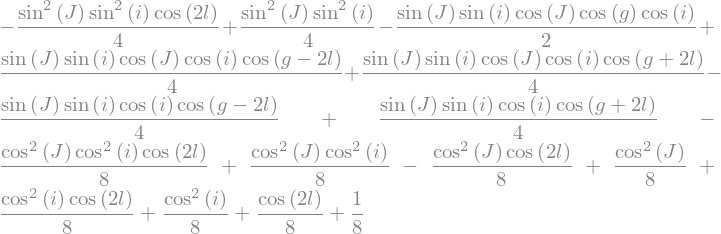

In [26]:
# Also include resonances with +- 2l
_terms_tri = [
    (2*g), (2*M), (2*M + g), (2*M - g), (2*M - 2*g),(2*M + 2*g)
]
terms_tri = []
for t in _terms_tri:
    terms_tri.append(sp.cos(t))
for t in _terms_tri:
    terms_tri.append(sp.cos(t + 2 * l))
    terms_tri.append(sp.cos(t - 2 * l))
    
rdotisq_sumandangle = sp.collect(
    rdotisq_sumandangle_t8,
    terms_tri,
).subs(mask_Ji_revert) / 8
remainder = rdotisq_sumandangle
for t in terms_tri:
    display(sp.simplify(rdotisq_sumandangle.coeff(t)) * t)
    remainder -= rdotisq_sumandangle.coeff(t) * t

print('\nAnd remainder:')
display(sp.collect(remainder, terms_tri))

This remainder term contains *many* resonant terms with l in the resonant angle. Note that dl/dt ~ Lambda(1/C-1/A) ~ Omega(C-A)/A is slowly varying, and is at similar order to dh/dt. 

## Hamiltonians

### 2:1

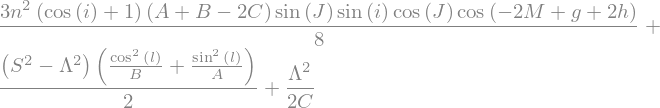

In [24]:
rdotksq_21 = sp.simplify(rdotksq_sumandangle.coeff(sp.cos(2 * M - g))) * sp.cos(2 * M - 2 * h - g)
rdotisq_21 = sp.simplify(rdotisq_sumandangle.coeff(sp.cos(2 * M - g))) * sp.cos(2 * M - 2 * h - g)
V_tri_withdot21 = sp.simplify(sp.factor(V_tri.subs({rz_b**2: rdotksq_21, rx_b**2: rdotisq_21})))
# not yet canonical
H_tri_nc21 = T + V_tri_withdot21
display(H_tri_nc21)

Putting this into canonical form is not much more insightful...

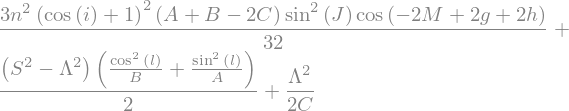

In [25]:
rdotksq_11 = sp.simplify(rdotksq_sumandangle.coeff(sp.cos(2 * M - 2 * g))) * sp.cos(2 * M - 2 * h - 2 * g)
rdotisq_11 = sp.simplify(rdotisq_sumandangle.coeff(sp.cos(2 * M - 2 * g))) * sp.cos(2 * M - 2 * h - 2 * g)
V_tri_withdot11 = sp.simplify(sp.factor(V_tri.subs({rz_b**2: rdotksq_11, rx_b**2: rdotisq_11})))
# not yet canonical
H_tri_nc11 = T + V_tri_withdot11
display(H_tri_nc11)